# **Setup the environment**

In [1]:
%%capture
!pip install -q scanpy==1.10.1
!pip install -q anndata==0.10.7
!pip install -q squidpy==1.6.1
!pip install -q rasterio==1.4.3
!pip install -q google-cloud-storage

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
from matplotlib import pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns
import rasterio

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth # Authenticate your Colab environment to access your Google Cloud account.
auth.authenticate_user()

Mounted at /content/drive


# **Load annotated scanpy instance**

In [5]:
ad = sc.read_h5ad("/content/drive/MyDrive/Cancer sc analysis/HumanUterineCancerPatient2-ROCostain_annotated.hdf5")
ad

AnnData object with n_obs × n_vars = 74392 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Anti-Ms-CD45RO_raw', 'Anti-Ms-CD45RO_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'Cellbound2_raw', 'Cellbound2_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'barcodeCount', 'volume_factor', 'leiden', 'manual_annot'
    var: 'mean', 'std'
    uns: 'dendrogram_leiden', 'leiden', 'leiden_colors', 'log1p', 'manual_annot_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

# **Neighborhood Enrichment Test**
https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_vizgen_mouse_liver.html#neighborhood-enrichment

This test determines if cells belonging to two different clusters are close to each other more often than expected.

In [6]:
import matplotlib as mpl

# Set the global pad default
mpl.rcParams['figure.subplot.hspace'] = 0  # set the global padding to make dendrogram and heatmap closer

Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['manual_annot_nhood_enrichment']`
Finish (0:00:09)


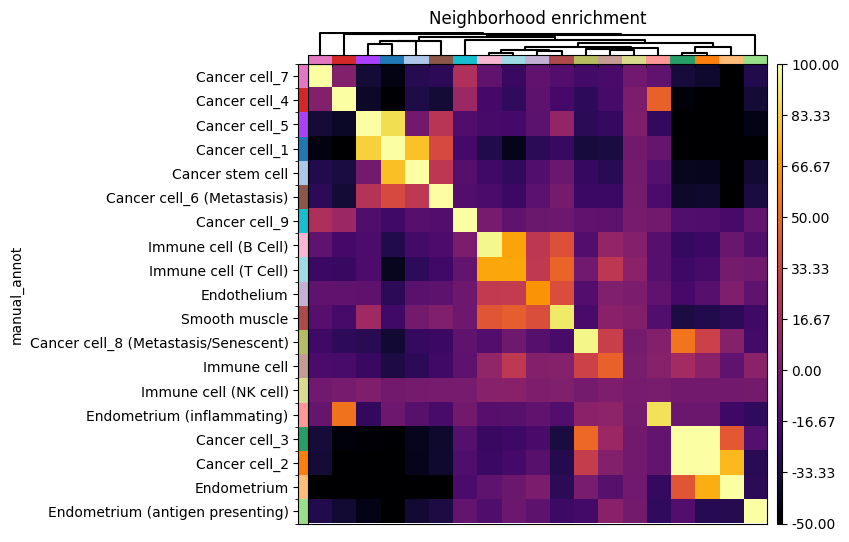

In [7]:
sq.gr.spatial_neighbors(ad, coord_type="generic", spatial_key="spatial") # calculate a connectivity graph

# test among manual annotated clusters
sq.gr.nhood_enrichment(ad, cluster_key="manual_annot")
sq.pl.nhood_enrichment(
    ad,
    cluster_key="manual_annot",
    method="average",
    cmap="inferno",
    vmin=-50,
    vmax=100,
    figsize=(5, 5),
)

By visually inspecting the heatmap (Z-scores), there are:

1. **Identifiable Meta-clusters:** Three meta-clusters emerge, highlighted by light-colored squares (indicating higher positive Z-scores, meaning a group is enriched in the neighborhood of another group):

    * Meta-cluster 1: ['Cancer stem cell', 'Cancer cell_1', 'Cancer cell_5', 'Cancer cell_6 (Metastasis)']

        * Interpretation: Cancer stem cell, Cancer cell_1, and Cancer cell_5 might form a concentric structure, while Cancer cell_6 appears to be more dispersed within the microenvironment.
    * Meta-cluster 2: ['Immune cell (B Cell)', 'Immune cell (T Cell)', 'Endothelium', 'Smooth muscle']

        * Interpretation: Represents the immune cell population and their associated blood vessel structures.
    * Meta-cluster 3: ['Cancer cell_3', 'Cancer cell_2', 'Endometrium']

        * Interpretation: A distinct cancer cell cluster associated with endometrial cells.
2. **Depletion Regions:** Two dark-colored squares (indicating lower Z-scores) suggest groups that are depleted in each other's neighborhoods:

    * Meta-cluster 4: ['Cancer cell_7', 'Cancer cell_4'] in relation to Meta-cluster 1.
    * Meta-cluster 5: ['Cancer cell_3', 'Cancer cell_2', 'Endometrium', 'Endometrium (antigen presenting)'] in relation to Meta-clusters 1 and 4.
3. **Dispersed Cell Type:**

    * 'Immune cell (NK cell)' exhibits minimal variability in Z-scores across the heatmap, suggesting this population is evenly dispersed among other cell groups.

**Next Steps:**
To validate these observations, we can test these meta-clusters by plotting them individually on the spatial map

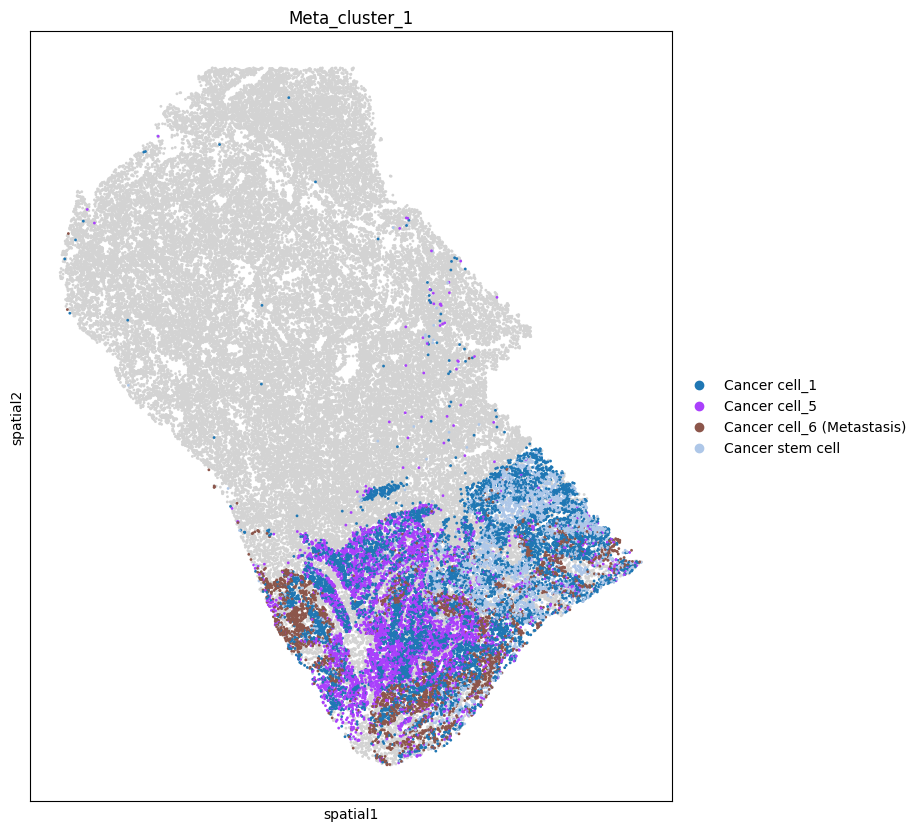

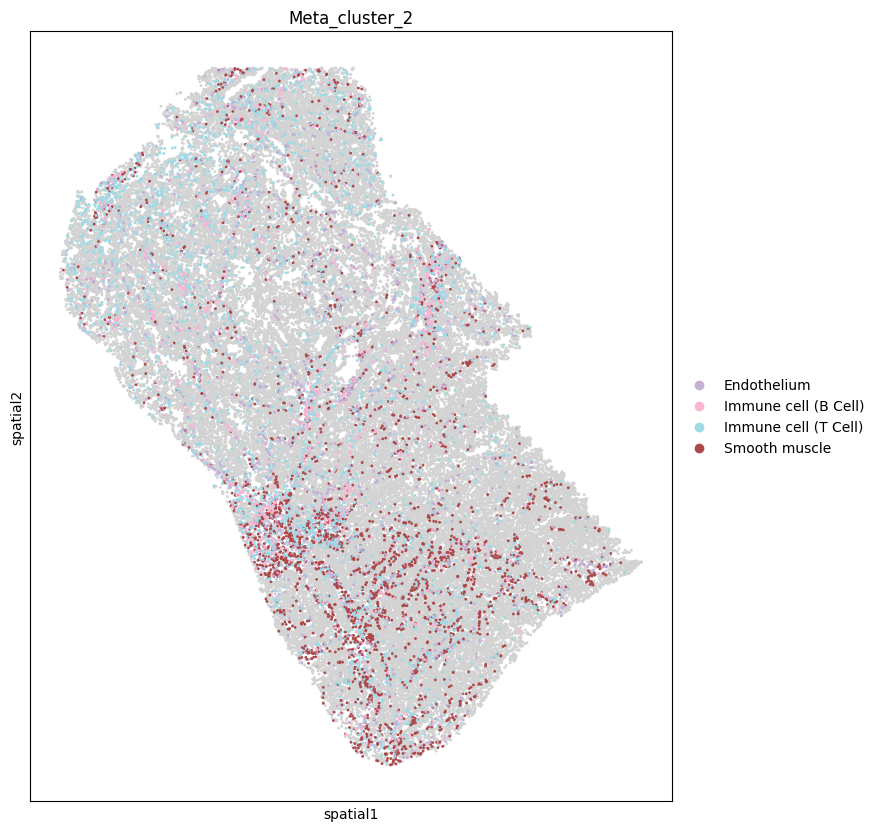

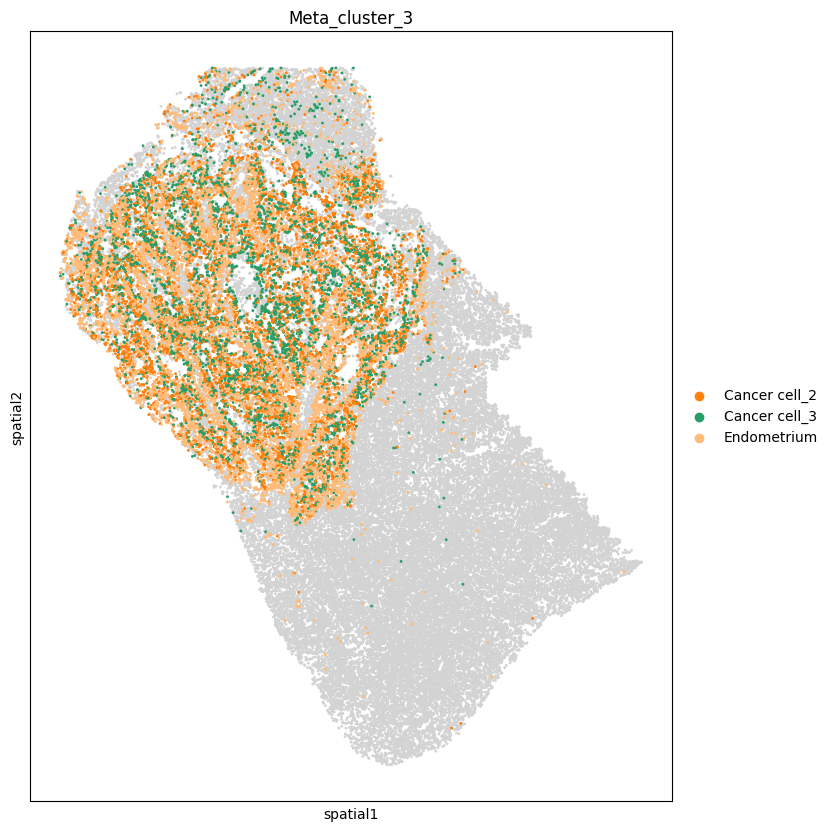

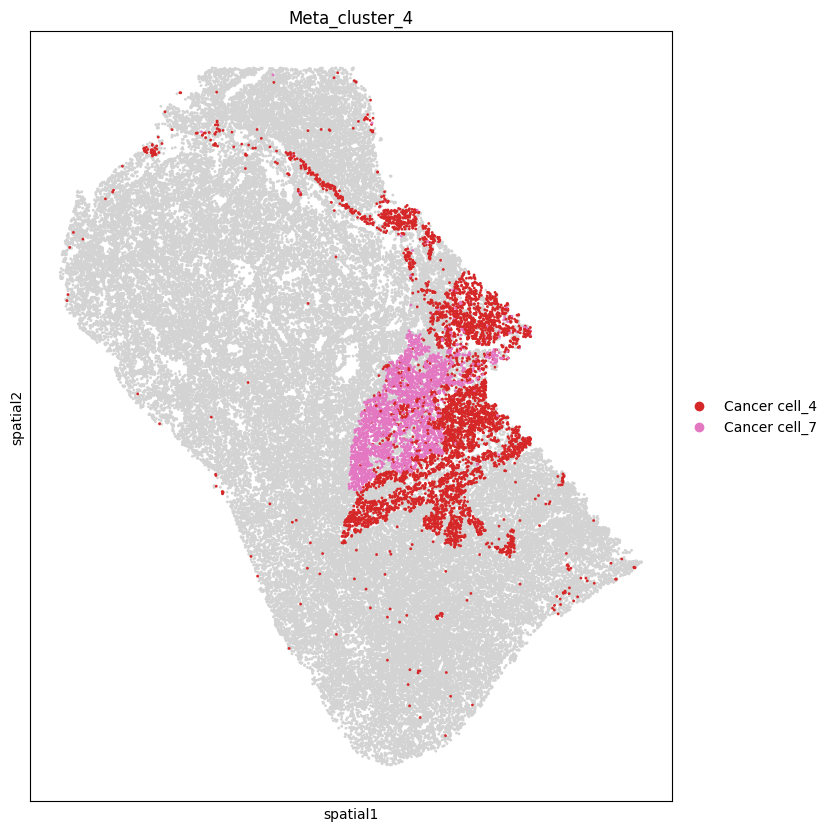

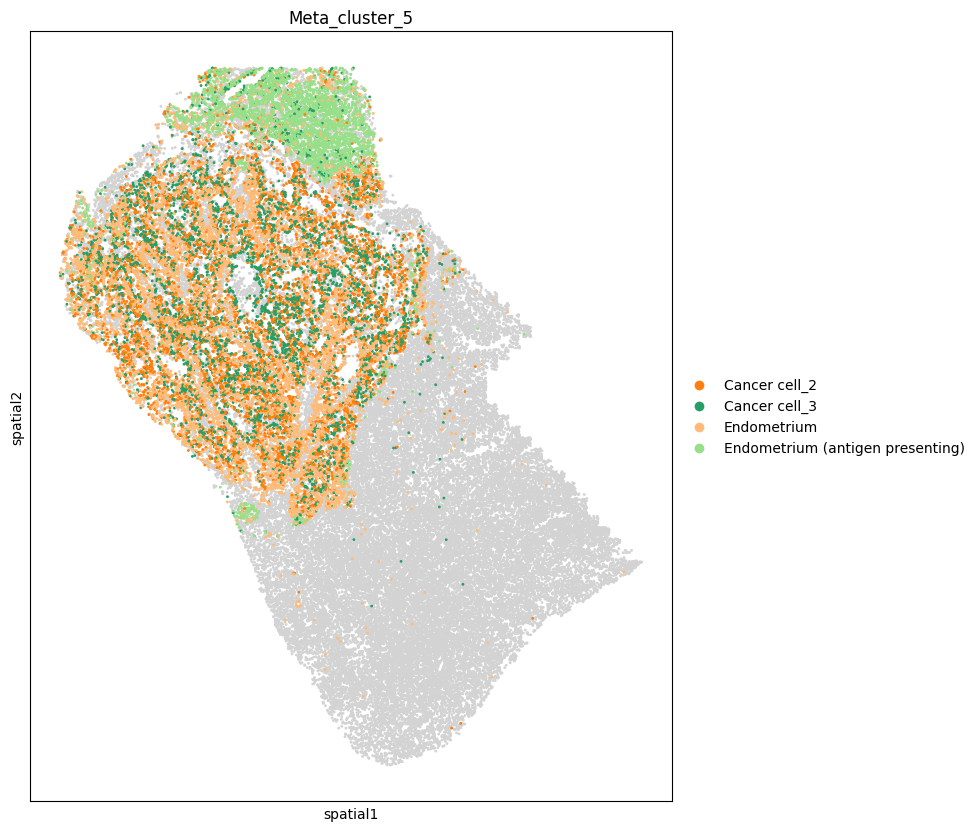

In [8]:
meta_clusters_dict = {
    'Meta_cluster_1' : ['Cancer stem cell', 'Cancer cell_1', 'Cancer cell_5', 'Cancer cell_6 (Metastasis)'],
    'Meta_cluster_2' : ['Immune cell (B Cell)', 'Immune cell (T Cell)', 'Endothelium', 'Smooth muscle'],
    'Meta_cluster_3' : ['Cancer cell_3', 'Cancer cell_2', 'Endometrium'],
    'Meta_cluster_4' : ['Cancer cell_7', 'Cancer cell_4'],
    'Meta_cluster_5' : ['Cancer cell_3', 'Cancer cell_2', 'Endometrium', 'Endometrium (antigen presenting)'],
                        }

# add vizually defined meta_cluster to obs
ad.obs['manual_meta_cluster'] = None

for n in [1, 2, 4, 5]:  # Meta-cluster 5 already includes meta-cluster 3
    ad.obs['manual_meta_cluster'] = ad.obs.apply(
        lambda row: f'Meta_cluster_{n}' if row['manual_annot'] in meta_clusters_dict[f'Meta_cluster_{n}'] else row['manual_meta_cluster'],
        axis=1
    )

# set ordered category to meta-cluster
from pandas.api.types import CategoricalDtype

meta_order = [f'Meta_cluster_{n}' for n in [1, 2, 4, 5]]
ordered_cat = CategoricalDtype(categories=meta_order, ordered=True)

# Apply the CategoricalDtype to the column
ad.obs['manual_meta_cluster'] = ad.obs['manual_meta_cluster'].astype(ordered_cat)


ad.obs['manual_meta_cluster']

with rc_context({'figure.figsize': (10, 10)}):
    for key, val in meta_clusters_dict.items():
        sc.pl.spatial(
                ad,
                groups= val,
                color="manual_annot",
                spot_size=50,
                na_in_legend=False,
                title = key
            )

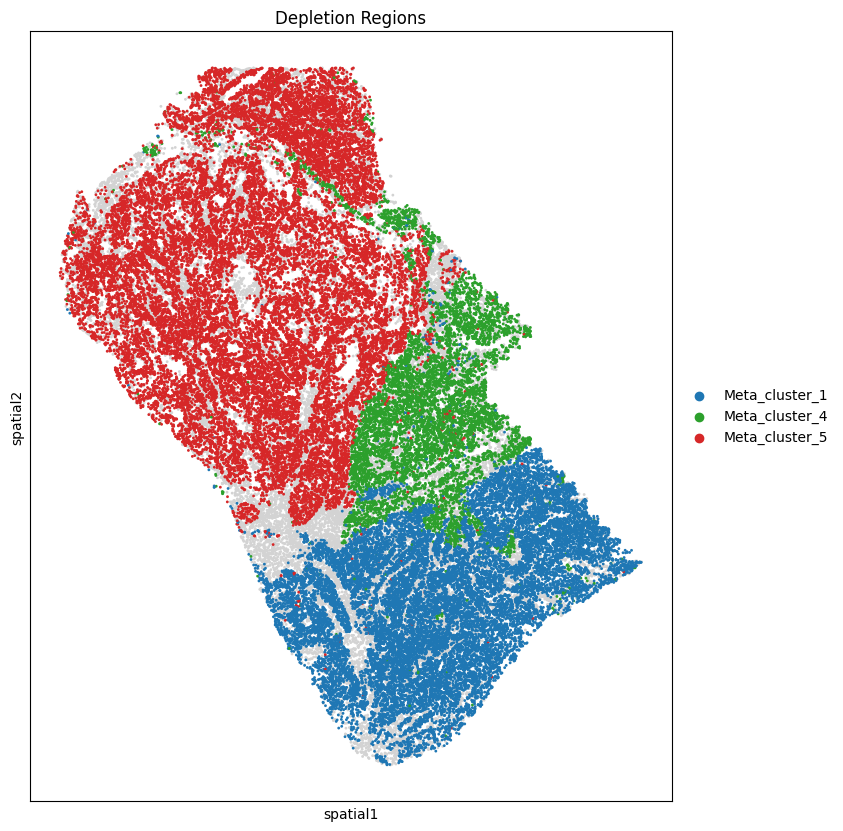

In [9]:
# visualize mutual depletion regions

meta_n = [1, 4, 5]

with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.spatial(
            ad,
            color="manual_meta_cluster",
            groups = [f'Meta_cluster_{n}' for n in meta_n],
            spot_size=50,
            na_in_legend=False,
            title = 'Depletion Regions'
        )

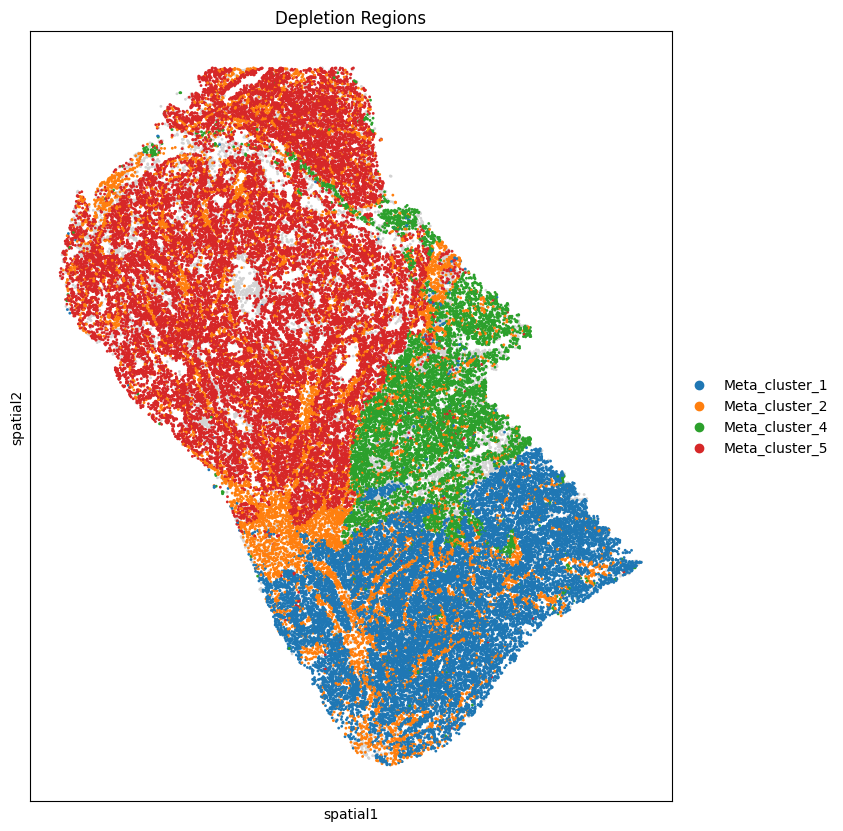

In [10]:
# meta-cluster 2 (blood and capillary cells) seems complementary to the above mutual depletion regions
# Add meta-cluster 2 to the plot

meta_n = [1, 2, 4, 5]

with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.spatial(
            ad,
            color="manual_meta_cluster",
            groups = [f'Meta_cluster_{n}' for n in meta_n],
            spot_size=50,
            na_in_legend=False,
            title = 'Depletion Regions'
        )

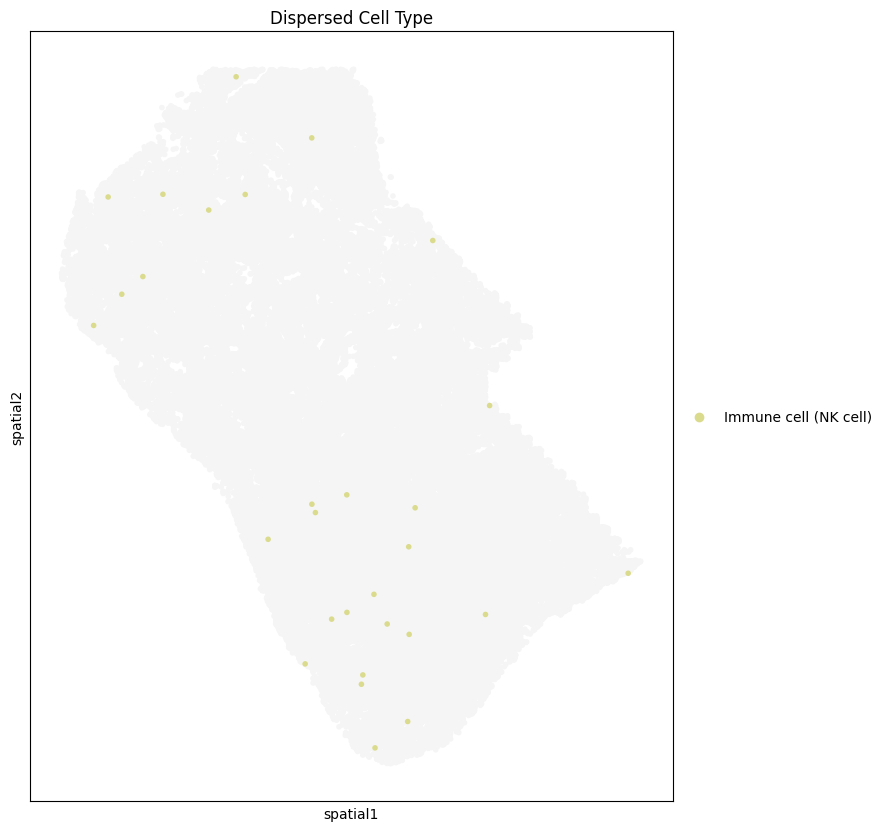

There are total 29 of Immune cell (NK cell) out of total 74392 cells


In [11]:
# visualize dispersed cell type:

with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.spatial(
            ad,
            groups = ['Immune cell (NK cell)'],
            color="manual_annot",
            na_color = '#F5F5F5', # 'Immune cell (NK cell)' color is too light to be distinguished from the rest cells
            spot_size=100,
            na_in_legend=False,
            title = 'Dispersed Cell Type'
        )

print(f"There are total {np.sum(ad.obs['manual_annot'] == 'Immune cell (NK cell)')} of Immune cell (NK cell) out of total {len(ad.obs)} cells")

**Observations:**

1. Meta-clusters and Regions:

    * The meta-clusters form distinct regions, and areas of mutual depletion exhibit well-defined boundaries. Projecting these regions onto histology (IHC) images could provide additional insights into tissue zoning.

2. Limitations of Visual Inspection:

    * Visually identifying meta-clusters from the heatmap can be somewhat arbitrary and may overlook nuanced neighbor relationships. However, combining this approach with spatial visualization can make the analysis more straightforward and compelling.

3. Immune Cell (NK Cell) Representation:

    * There are too few Immune cell (NK cell) instances to draw a definitive conclusion about their even distribution among other cell groups.

# Project meta-clusters on IHC images
Following the previous comment #1, let's see if there is any tissue junctions at the meta-cluster boundaries

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(11826, 9835)


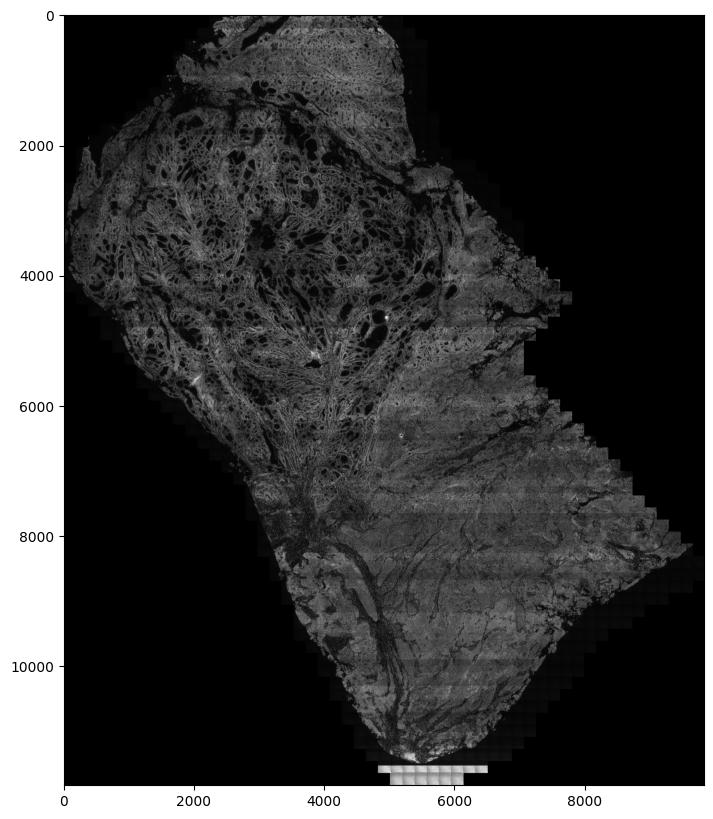

In [12]:
# test plot down-sized image

with rasterio.open('/content/drive/MyDrive/Cancer sc analysis/CD45RO_histology_img/mosaic_PolyT_downsized_z3.tif') as ihc:
    roi = ihc.read(1)

print(roi.shape)

plt.figure(figsize=(10,10))
plt.imshow(roi, cmap='gray')

In [13]:
# process cell x and y coordinates from micron to mosaic

## read micron_to_mosaic_transformation matrix

micron_to_mosaic = pd.read_csv('gs://vz-ffpe-showcase/HumanUterineCancerPatient2-ROCostain/images/micron_to_mosaic_pixel_transform.csv', header=None)
# display(micron_to_mosaic)

micron_to_mosaic = micron_to_mosaic[0].to_list()
micron_to_mosaic = [x.split(" ") for x in micron_to_mosaic]
micron_to_mosaic = np.asarray(micron_to_mosaic, dtype=float)

## transform cell x-y coordinates to the mosaic space
import shapely

def transform_to_mosaic_and_scale(x_in_micron, y_in_micron, micron_to_mosaic, scale_factor): #need to scale the coordinates to match the reduced size of the image
    point = np.array([[x_in_micron, y_in_micron]])
    scaled = np.matmul(point, micron_to_mosaic[0:2, 0:2])
    translated = np.array([scaled[0, 0] + micron_to_mosaic[0, 2], scaled[0, 1] + micron_to_mosaic[1, 2]])
    x, y = translated.ravel()
    # Scale the coordinates to match the reduced image size
    x_scaled = x / scale_factor
    y_scaled = y / scale_factor
    return x, y, shapely.geometry.Point(x, y), x_scaled, y_scaled

# Define the scale factor (e.g., image is 10 times smaller)
scale_factor = 10

# Apply the function and create scaled x and y columns
ad.obs[['x_in_mosaic', 'y_in_mosaic', 'x_y_in_mosaic', 'x_in_image', 'y_in_image']] = ad.obs.apply(
    lambda row: pd.Series(transform_to_mosaic_and_scale(row['center_x'], row['center_y'], micron_to_mosaic, scale_factor)), axis=1
)

# Display the updated dataframe
display(ad.obs.head())



fov       volume     center_x     center_y        min_x  \
267305200237100734   896   677.054660  3450.051943  5792.739723  3445.839596   
267305200301100626  1164   317.039127  3897.941731  7329.988505  3894.801862   
267305200279102714  1112  1130.893232  3457.306885  7144.257037  3450.740545   
267305200132102564   470  1562.016838  3171.987173  3550.734337  3166.614971   
267305200346101464  1358   449.286462  5703.113540  8440.972407  5698.221299   

                          min_y        max_x        max_y  anisotropy  \
267305200237100734  5786.606385  3454.819470  5797.607057    1.283046   
267305200301100626  7326.968789  3902.088199  7333.442881    1.370718   
267305200279102714  7138.134283  3463.574176  7150.671673    1.255589   
267305200132102564  3540.229725  3178.405814  3560.473748    1.721142   
267305200346101464  8437.865899  5707.064785  8445.156656    1.327251   

                    transcript_count  ...  barcodeCount  volume_factor  \
267305200237100734               474  ...           479       1.051830   
267305200301100626               439  ...           443       0.492532   
267305200279102714               849  ...           858       1.756885   
267305200132102564               908  ...           916       2.426652   
267305200346101464               306  ...           307       0.697984   

                    leiden          manual_annot  manual_meta_cluster  \
267305200237100734       7           Immune cell                  NaN   
267305200301100626       6           Endometrium       Meta_cluster_5   
267305200279102714       8  Immune cell (T Cell)       Meta_cluster_2   
267305200132102564       7           Immune cell                  NaN   
267305200346101464       0         Cancer cell_1       Meta_cluster_1   

                     x_in_mosaic   y_in_mosaic  \
267305200237100734  31945.251007  53636.931709   
267305200301100626  36092.420943  67870.836893   
267305200279102714  32012.427087  66151.086557   
267305200132102564  29370.550967  32877.447337   
267305200346101464  52807.145107  78157.811717   

                                                   x_y_in_mosaic   x_in_image  \
267305200237100734   POINT (31945.25100700209 53636.93170911981)  3194.525101   
267305200301100626    POINT (36092.42094308605 67870.8368931396)  3609.242094   
267305200279102714  POINT (32012.427086576885 66151.08655709126)  3201.242709   
267305200132102564  POINT (29370.550966681116 32877.44733688149)  2937.055097   
267305200346101464   POINT (52807.14510674034 78157.81171747815)  5280.714511   

                     y_in_image  
267305200237100734  5363.693171  
267305200301100626  6787.083689  
267305200279102714  6615.108656  
267305200132102564  3287.744734  
267305200346101464  7815.781172  

[5 rows x 34 columns]

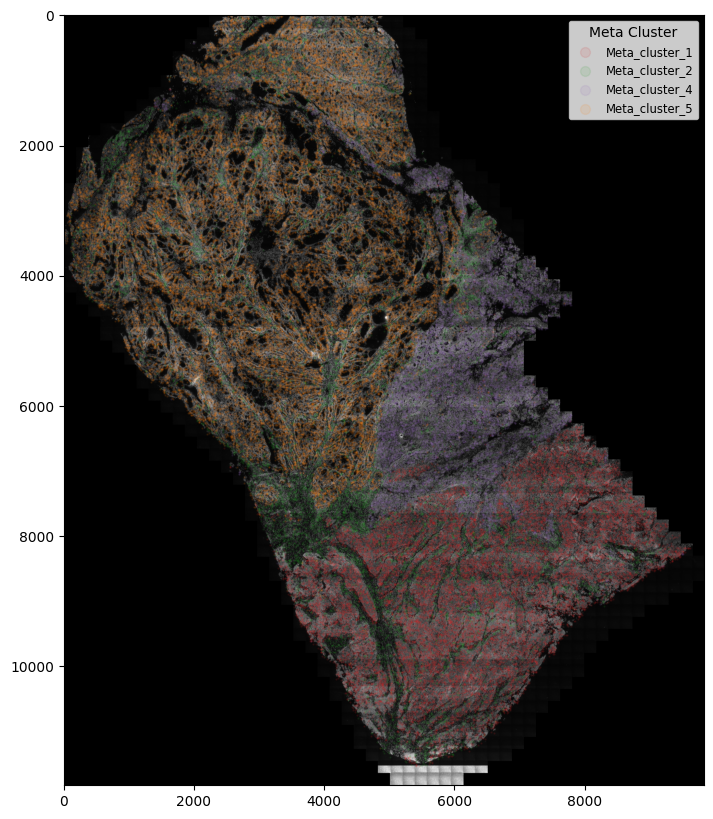

In [14]:
# Project meta-clusters on histology image

# Get Matplotlib's default color cycle
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Assign colors to categories
unique_categories = ad.obs['manual_meta_cluster'].unique()
color_map = {category: default_colors[i % len(default_colors)] for i, category in enumerate(unique_categories)}

# Map colors to a new column in the dataframe
ad.obs['color'] = ad.obs['manual_meta_cluster'].map(color_map)

# Plot the scatter plot with colors
plt.figure(figsize=(10, 10))

plt.imshow(roi, cmap='gray')

# Plot each category separately for the legend
for cat in ad.obs['manual_meta_cluster'].cat.categories:
    category_data = ad.obs[ad.obs['manual_meta_cluster'] == cat]
    plt.scatter(
        category_data['x_in_image'],
        category_data['y_in_image'],
        s=0.5,
        alpha=0.1,
        c=color_map[cat],
        label=cat
    )

# Add legend
plt.legend(title="Meta Cluster", markerscale=10, loc='upper right', fontsize='small')

plt.show()


<strong>Observations:</strong>
                <ol>
                    <li>
                        From this meta-cluster-tissue projection, it is evident that <strong>Meta-cluster_5</strong> (<span style="color: orange;">orange</span>) forms a more porous domain compared to <strong>Meta-cluster_1</strong> (<span style="color: red;">red</span>) and <strong>Meta-cluster_4</strong> (<span style="color: purple;">purple</span>).
                        Additionally, <strong>Meta-cluster_1</strong> has more blood vessels traversing through it (associated with <strong>Meta-cluster_2</strong>, <span style="color: green;">green</span>) than <strong>Meta-cluster_4</strong>, suggesting different phases of tumor progression.
                    </li>
                    <li>
                        As previously mentioned, visually identifying meta-clusters from the heatmap can be somewhat arbitrary.
                        However, the current meta-classification faithfully reflects tissue zonations to a certain extent.
                        Grouping cell types into meta-clusters based on spatial information—alongside granular cell typing based solely on gene expression—provides a broader perspective on general cell types within tissues and their associated cellular interactions.
                    </li>
                </ol>

# Further characterize the meta-clusters.
## DGE among meta-clusters


If I directly perform rank_gene_groups among meta_clusters, it returns warning like:</br>
RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(

Additionally, the some of logfoldchanges are NaN eventhough the z-scores are high.

In [15]:
col_for_dge = 'manual_meta_cluster'

# subset ad for DGE
ad_sub = ad[~ad.obs[col_for_dge].isna()].copy()

# Run rank genes groups analysis
sc.tl.rank_genes_groups(ad_sub, col_for_dge, method='wilcoxon', use_raw=False, key_added = f'{col_for_dge}_rank_genes_groups')
sc.get.rank_genes_groups_df(ad_sub, group = None, key = f'{col_for_dge}_rank_genes_groups')

ranking genes
    finished: added to `.uns['manual_meta_cluster_rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


group   names      scores  logfoldchanges  pvals  pvals_adj
0     Meta_cluster_1    SOX2  137.107162             NaN    0.0        0.0
1     Meta_cluster_1   HDAC1  112.897232             NaN    0.0        0.0
2     Meta_cluster_1    JUNB  111.635643             NaN    0.0        0.0
3     Meta_cluster_1    ATF3  111.608902             NaN    0.0        0.0
4     Meta_cluster_1    BST2  106.468628             NaN    0.0        0.0
...              ...     ...         ...             ...    ...        ...
1995  Meta_cluster_5    EGR1  -91.208305             NaN    0.0        0.0
1996  Meta_cluster_5   STAT1  -91.877403             NaN    0.0        0.0
1997  Meta_cluster_5  IFITM1  -93.276642             NaN    0.0        0.0
1998  Meta_cluster_5     SMO  -99.649857             NaN    0.0        0.0
1999  Meta_cluster_5    LRP1 -141.095047             NaN    0.0        0.0

[2000 rows x 6 columns]

normalizing counts per cell
    finished (0:00:00)
ranking genes
    finished: added to `.uns['manual_meta_cluster_rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


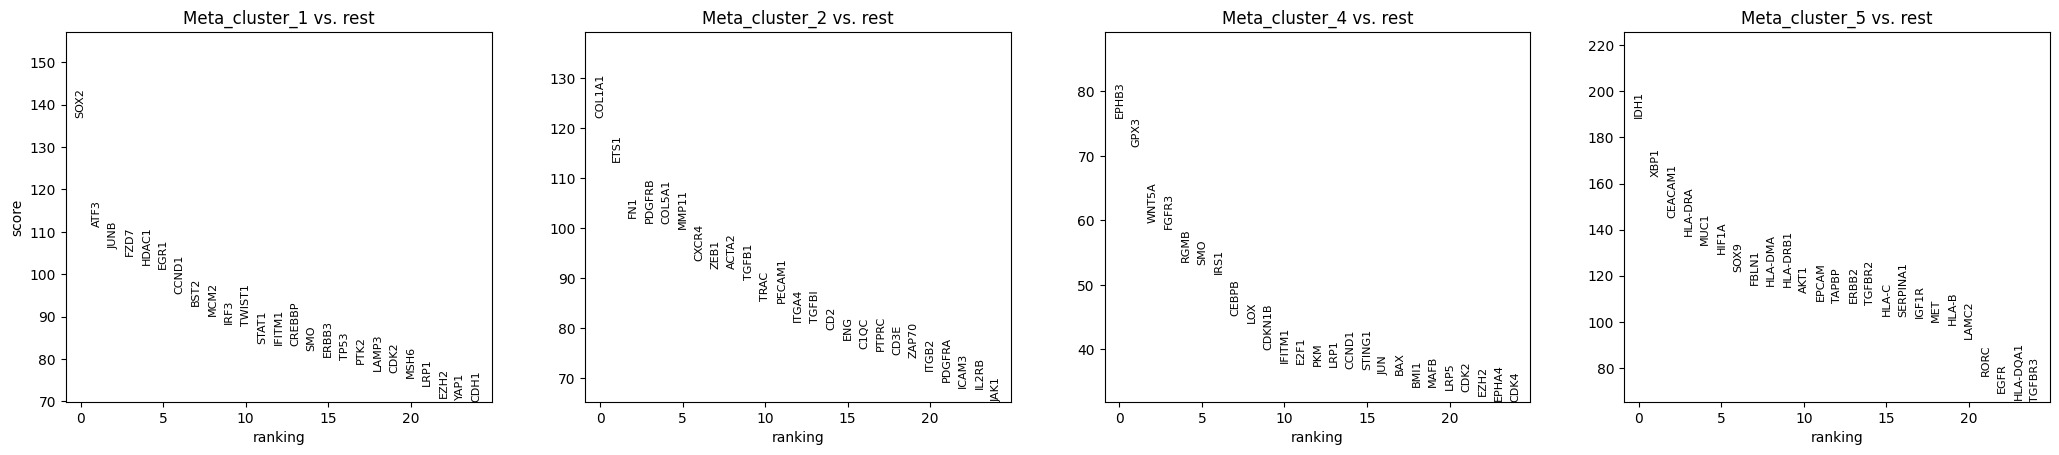

group   names      scores  logfoldchanges  pvals  pvals_adj
0     Meta_cluster_1    SOX2  136.996964             NaN    0.0        0.0
1     Meta_cluster_1    ATF3  111.116356             NaN    0.0        0.0
2     Meta_cluster_1    JUNB  106.055168             NaN    0.0        0.0
3     Meta_cluster_1    FZD7  104.250092             NaN    0.0        0.0
4     Meta_cluster_1   HDAC1  102.198357             NaN    0.0        0.0
...              ...     ...         ...             ...    ...        ...
1995  Meta_cluster_5    EGR1  -89.165825             NaN    0.0        0.0
1996  Meta_cluster_5  TWIST1  -89.398811             NaN    0.0        0.0
1997  Meta_cluster_5  IFITM1  -92.278236             NaN    0.0        0.0
1998  Meta_cluster_5     SMO  -99.657692             NaN    0.0        0.0
1999  Meta_cluster_5    LRP1 -139.785721             NaN    0.0        0.0

[2000 rows x 6 columns]

In [16]:
col_for_dge = 'manual_meta_cluster'

# subset ad for DGE
ad_sub = ad[~ad.obs[col_for_dge].isna()].copy()

# replace .X with raw.X
ad_sub.X = ad_sub.raw.X.copy()

#normalize the total reads of each cell to 1M
sc.pp.normalize_total(ad_sub, target_sum=1e6)
sc.pp.log1p(ad_sub)
#scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(ad_sub, max_value=10)


# Run rank genes groups analysis
sc.tl.rank_genes_groups(ad_sub, col_for_dge, method='wilcoxon', use_raw=False, key_added = f'{col_for_dge}_rank_genes_groups')
sc.pl.rank_genes_groups(ad_sub, n_genes=25, sharey=False, key = f'{col_for_dge}_rank_genes_groups')

sc.get.rank_genes_groups_df(ad_sub, group = None, key = f'{col_for_dge}_rank_genes_groups')

In [17]:
sc.get.rank_genes_groups_df(ad, group = None, key = 'rank_genes_groups')[sc.get.rank_genes_groups_df(ad, group = None, key = 'rank_genes_groups')['logfoldchanges'].isna()]

Empty DataFrame
Columns: [group, names, scores, logfoldchanges, pvals, pvals_adj]
Index: []

According to this Scanpy issue (https://github.com/scverse/scanpy/issues/653), performing differential gene expression (DGE) analysis after subsetting the original dataset requires re-normalizing the raw counts of the subset. This is necessary because the total counts over all genes (the denominator) from subset's cell-by-gene count table differs from the original table. Additionally, as noted in this comment (https://github.com/scverse/scanpy/issues/653#issuecomment-494353628) and this comment (https://github.com/scverse/scanpy/issues/653#issuecomment-494539920), scaling can introduce negative fold changes in subset data, which are not log-transformed and result in NaN values in the fold-change output. Therefore, I reused the raw count table after subsetting, normalized and log-transformed the raw counts without applying scaling. The resulting data is more reliable and interpretable.

Note: I checked the rank_genes_groups result table from the full dataset and found no NaN values in the fold-change output, even though the full dataset was scaled. At this point, I am unsure of the exact reason for this. However, the z-scores of differential gene expression (DGE) in the subset data, whether scaled or not, show no noticeable differences. To maintain consistency and to obtain the log2 fold-change values, I opted to skip scaling in the subset data before performing DGE.

normalizing counts per cell
    finished (0:00:00)
ranking genes
    finished: added to `.uns['manual_meta_cluster_rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)


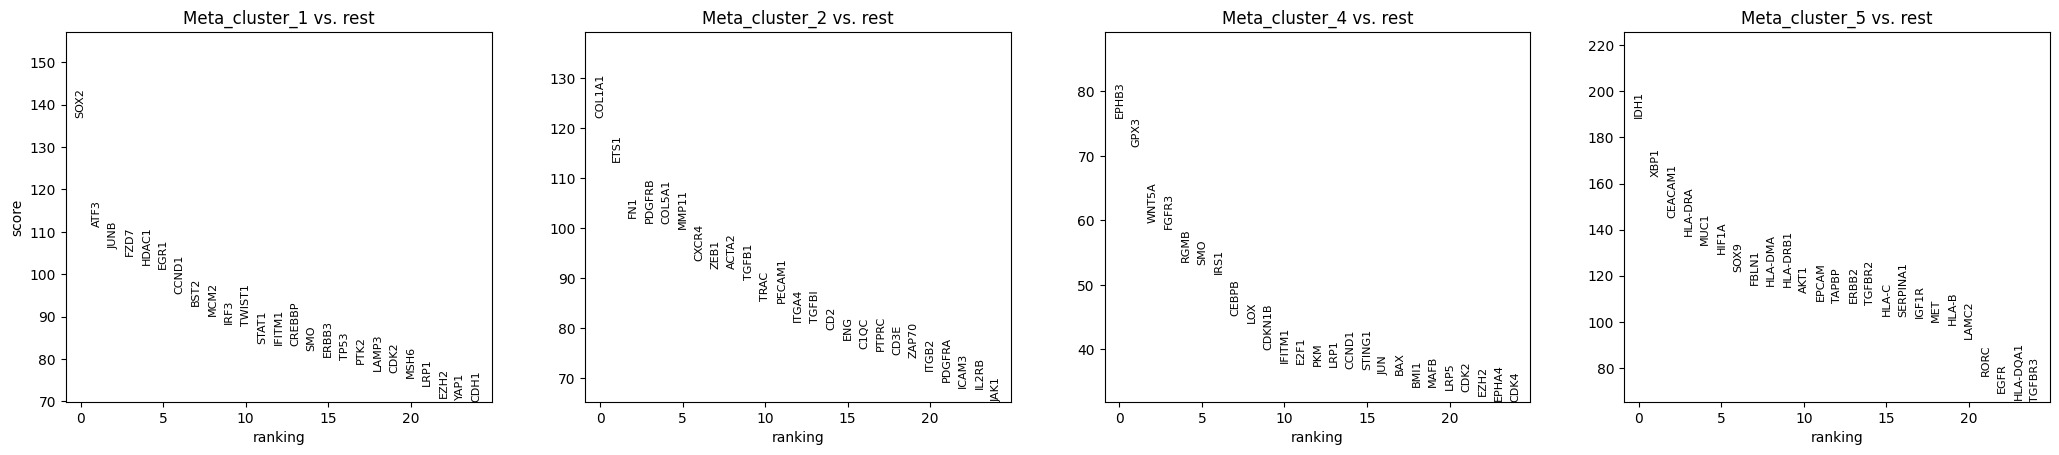

In [18]:
col_for_dge = 'manual_meta_cluster'

# subset ad for DGE
ad_sub = ad[~ad.obs[col_for_dge].isna()].copy()

# replace .X with raw.X
ad_sub.X = ad_sub.raw.X.copy()

#normalize the total reads of each cell to 1M
sc.pp.normalize_total(ad_sub, target_sum=1e6)
sc.pp.log1p(ad_sub)
# skip scaling to avoid neagative values and nan in log2fc
# sc.pp.scale(ad_sub, max_value=10)

# Run rank genes groups analysis
sc.tl.rank_genes_groups(ad_sub, col_for_dge, method='wilcoxon', use_raw=False, key_added = f'{col_for_dge}_rank_genes_groups')
sc.pl.rank_genes_groups(ad_sub, n_genes=25, sharey=False, key = f'{col_for_dge}_rank_genes_groups')

In [19]:
# get the DGE table
top_n = 10

rgdf = sc.get.rank_genes_groups_df(ad_sub, group = None, key = f'{col_for_dge}_rank_genes_groups')
display(rgdf.sort_values(['group', 'logfoldchanges'], ascending = False).groupby('group', observed=True).head(top_n))

group     names      scores  logfoldchanges          pvals  \
1502  Meta_cluster_5   CEACAM1  144.978317        7.814463   0.000000e+00   
1506  Meta_cluster_5      SOX9  121.567993        6.937330   0.000000e+00   
1516  Meta_cluster_5  SERPINA1  102.295502        5.909581   0.000000e+00   
1507  Meta_cluster_5     FBLN1  116.237968        5.776731   0.000000e+00   
1518  Meta_cluster_5       MET  100.231468        5.554249   0.000000e+00   
1508  Meta_cluster_5   HLA-DMA  115.672401        4.799101   0.000000e+00   
1514  Meta_cluster_5    TGFBR2  107.221581        4.793928   0.000000e+00   
1509  Meta_cluster_5  HLA-DRB1  115.094795        4.722160   0.000000e+00   
1517  Meta_cluster_5     IGF1R  101.779976        4.708678   0.000000e+00   
1521  Meta_cluster_5      RORC   76.504440        4.706554   0.000000e+00   
1001  Meta_cluster_4      GPX3   71.403793        5.732186   0.000000e+00   
1003  Meta_cluster_4     FGFR3   58.659039        5.726293   0.000000e+00   
1000  Meta_cluster_4     EPHB3   75.957428        5.717287   0.000000e+00   
1002  Meta_cluster_4     WNT5A   59.551880        4.676034   0.000000e+00   
1005  Meta_cluster_4       SMO   53.102921        4.595241   0.000000e+00   
1008  Meta_cluster_4       LOX   44.176140        4.103013   0.000000e+00   
1006  Meta_cluster_4      IRS1   51.786270        3.892448   0.000000e+00   
1013  Meta_cluster_4      LRP1   37.265701        3.634029  5.900695e-304   
1004  Meta_cluster_4      RGMB   53.590412        3.602625   0.000000e+00   
1015  Meta_cluster_4    STING1   36.870068        3.522054  1.395039e-297   
504   Meta_cluster_2    COL5A1  100.948509        8.697311   0.000000e+00   
503   Meta_cluster_2    PDGFRB  101.033646        8.472700   0.000000e+00   
502   Meta_cluster_2       FN1  102.131340        7.978997   0.000000e+00   
507   Meta_cluster_2      ZEB1   91.880325        7.655385   0.000000e+00   
506   Meta_cluster_2     CXCR4   93.497566        7.497314   0.000000e+00   
514   Meta_cluster_2       CD2   79.583755        7.469660   0.000000e+00   
510   Meta_cluster_2      TRAC   85.442253        7.433536   0.000000e+00   
501   Meta_cluster_2      ETS1  113.232307        7.317605   0.000000e+00   
518   Meta_cluster_2      CD3E   74.769516        7.279010   0.000000e+00   
511   Meta_cluster_2    PECAM1   85.053413        7.137346   0.000000e+00   
0     Meta_cluster_1      SOX2  136.996964        9.080658   0.000000e+00   
3     Meta_cluster_1      FZD7  104.250092        6.553047   0.000000e+00   
1     Meta_cluster_1      ATF3  111.116356        6.224110   0.000000e+00   
10    Meta_cluster_1    TWIST1   87.729713        5.695365   0.000000e+00   
14    Meta_cluster_1       SMO   81.947144        4.917541   0.000000e+00   
18    Meta_cluster_1     LAMP3   77.092613        4.862287   0.000000e+00   
5     Meta_cluster_1      EGR1  101.184639        4.815420   0.000000e+00   
12    Meta_cluster_1    IFITM1   83.446632        4.612342   0.000000e+00   
39    Meta_cluster_1       HGF   54.657837        4.499493   0.000000e+00   
21    Meta_cluster_1      LRP1   73.608955        4.399130   0.000000e+00   

          pvals_adj  
1502   0.000000e+00  
1506   0.000000e+00  
1516   0.000000e+00  
1507   0.000000e+00  
1518   0.000000e+00  
1508   0.000000e+00  
1514   0.000000e+00  
1509   0.000000e+00  
1517   0.000000e+00  
1521   0.000000e+00  
1001   0.000000e+00  
1003   0.000000e+00  
1000   0.000000e+00  
1002   0.000000e+00  
1005   0.000000e+00  
1008   0.000000e+00  
1006   0.000000e+00  
1013  1.404927e-302  
1004   0.000000e+00  
1015  3.032694e-296  
504    0.000000e+00  
503    0.000000e+00  
502    0.000000e+00  
507    0.000000e+00  
506    0.000000e+00  
514    0.000000e+00  
510    0.000000e+00  
501    0.000000e+00  
518    0.000000e+00  
511    0.000000e+00  
0      0.000000e+00  
3      0.000000e+00  
1      0.000000e+00  
10     0.000000e+00  
14     0.000000e+00  
18     0.000000e+00  
5      0.000000e+00  
12     0.000000e+00  

## Visualize DGE by volcano plots

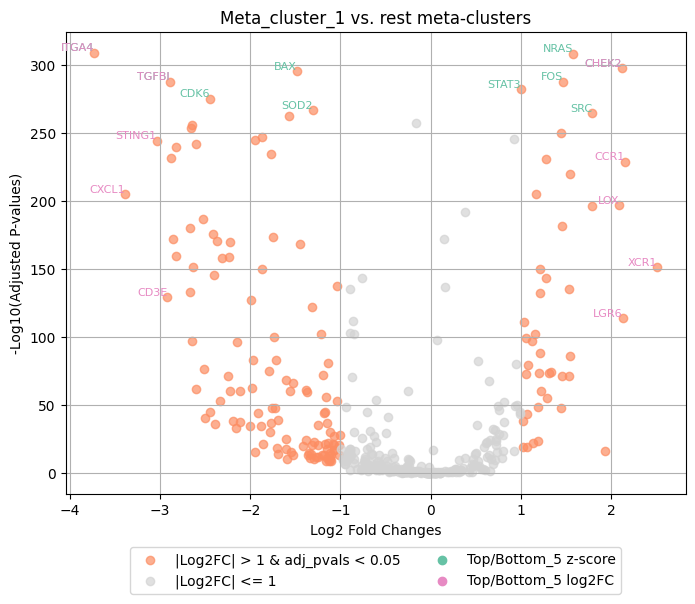

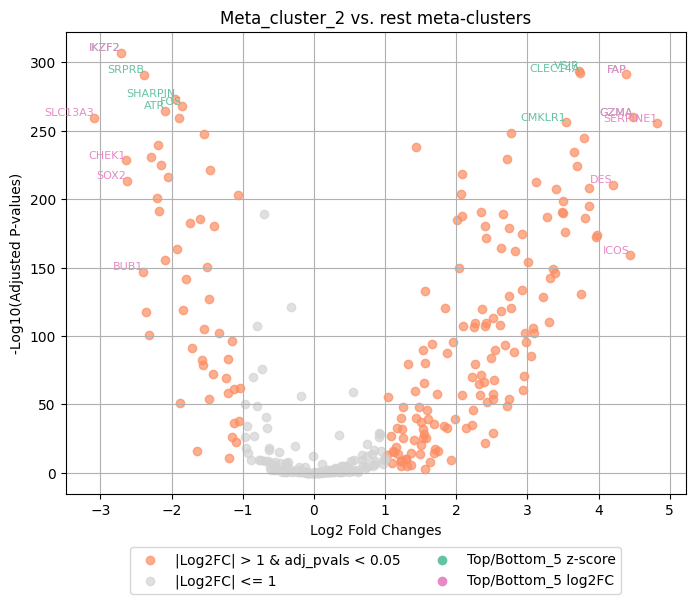

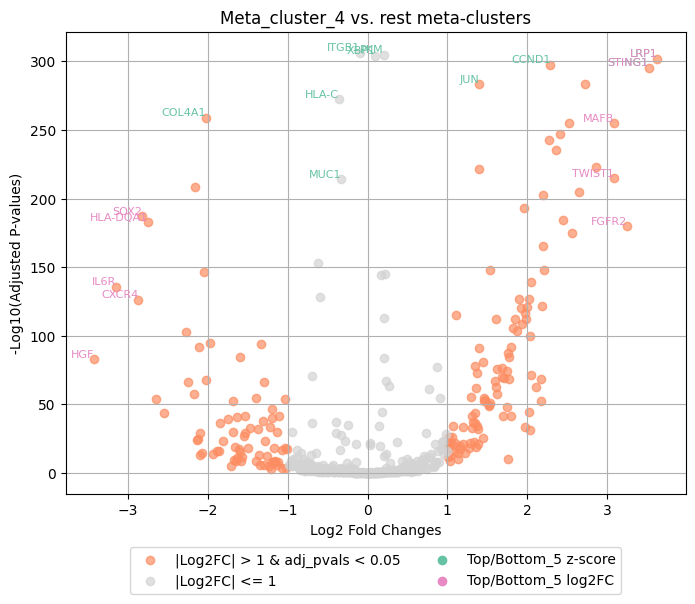

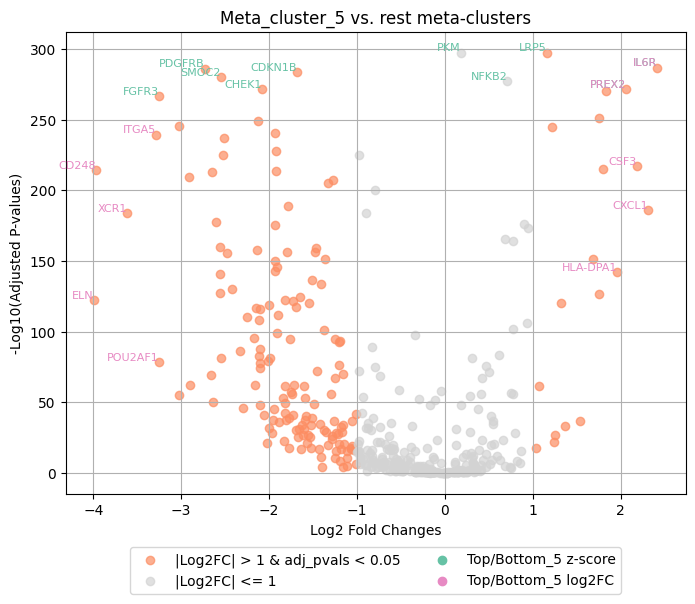

In [20]:
# Highlight top/bottom 5 scores and log2foldchange genes

# Filter out rows where -log10(pvals_adj) is not finite
rgdf["-log10(pvals_adj)"] = -np.log10(rgdf["pvals_adj"].replace(0, np.nan))
rgdf = rgdf[np.isfinite(rgdf["-log10(pvals_adj)"])]

# Create volcano plots with labels for top and bottom n logfoldchanges
n = 5  # Number of top and bottom labels
groups = rgdf["group"].unique()

# Updated code with magenta and light gray colors for specific spots
for group in groups:
    group_rgdf = rgdf[rgdf["group"] == group]

    # Sort and select top n and bottom n based on scores
    top_n_score = group_rgdf.nlargest(n, "scores")
    bottom_n_score = group_rgdf.nsmallest(n, "scores")
    labeled_points_score = pd.concat([top_n_score, bottom_n_score])

    top_n_fc = group_rgdf.nlargest(n, "logfoldchanges")
    bottom_n_fc = group_rgdf.nsmallest(n, "logfoldchanges")
    labeled_points_fc = pd.concat([top_n_fc, bottom_n_fc])

    plt.figure(figsize=(8, 6))

    # Plot points based on conditions for x-axis (logfoldchanges)
    plt.scatter(
        group_rgdf.loc[
            ((group_rgdf["logfoldchanges"] > 1) | (group_rgdf["logfoldchanges"] < -1)) & (group_rgdf["pvals_adj"] < 0.05),
            "logfoldchanges"
        ],
        group_rgdf.loc[
            ((group_rgdf["logfoldchanges"] > 1) | (group_rgdf["logfoldchanges"] < -1)) & (group_rgdf["pvals_adj"] < 0.05),
            "-log10(pvals_adj)"
        ],
        color='#fc8d62',
        alpha=0.7,
        label="|Log2FC| > 1 & adj_pvals < 0.05"
    )

    plt.scatter(
        group_rgdf.loc[
            (group_rgdf["logfoldchanges"] <= 1) & (group_rgdf["logfoldchanges"] >= -1),
            "logfoldchanges"
        ],
        group_rgdf.loc[
            (group_rgdf["logfoldchanges"] <= 1) & (group_rgdf["logfoldchanges"] >= -1),
            "-log10(pvals_adj)"
        ],
        color='lightgray',
        alpha=0.7,
        label="|Log2FC| <= 1"
    )

    # Add labels for the selected top/bottom n__score points
    for _, row in labeled_points_score.iterrows():
        plt.text(
            row["logfoldchanges"],
            row["-log10(pvals_adj)"],
            row["names"],
            fontsize=8,
            ha='right',
            va='bottom',
            color = '#66c2a5'
        )

    # Add labels for the selected top/bottom n__fc points
    for _, row in labeled_points_fc.iterrows():
        plt.text(
            row["logfoldchanges"],
            row["-log10(pvals_adj)"],
            row["names"],
            fontsize=8,
            ha='right',
            va='bottom',
            color = '#e78ac3'
        )

    # Add a custom legend for labeled points
    plt.scatter([], [], color='#66c2a5', label=f"Top/Bottom_{n} z-score")
    plt.scatter([], [], color='#e78ac3', label=f"Top/Bottom_{n} log2FC")

    plt.title(f"{group} vs. rest meta-clusters")
    plt.xlabel("Log2 Fold Changes")
    plt.ylabel("-Log10(Adjusted P-values)")
    # Place legend to the bottom of the plot
    plt.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.1),
        frameon=True,
        ncol=2
    )
    plt.grid(True)
    plt.show()


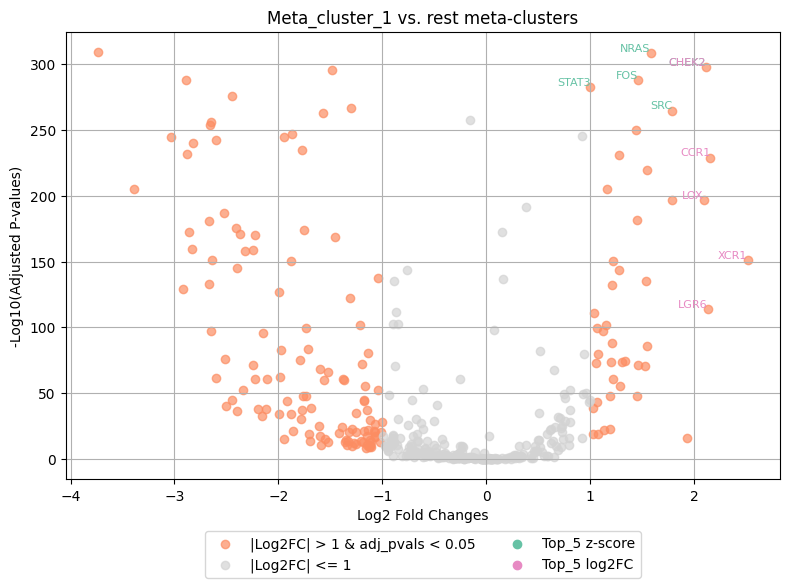

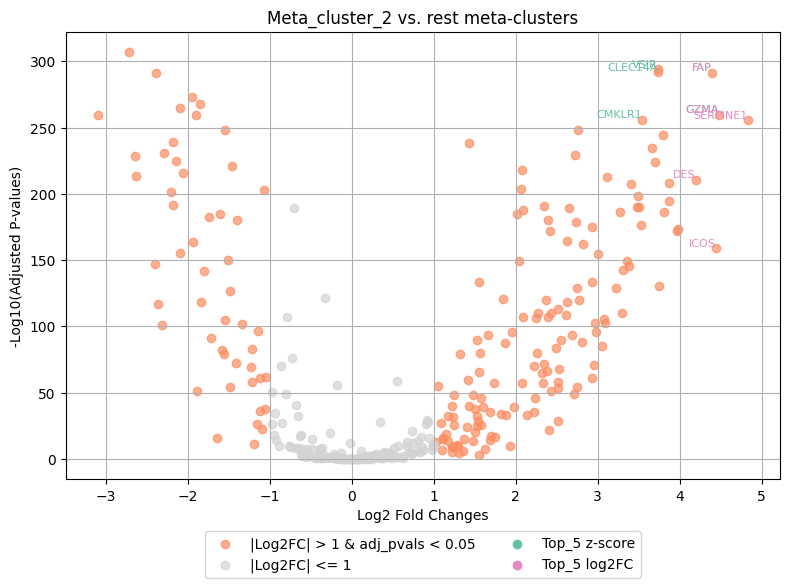

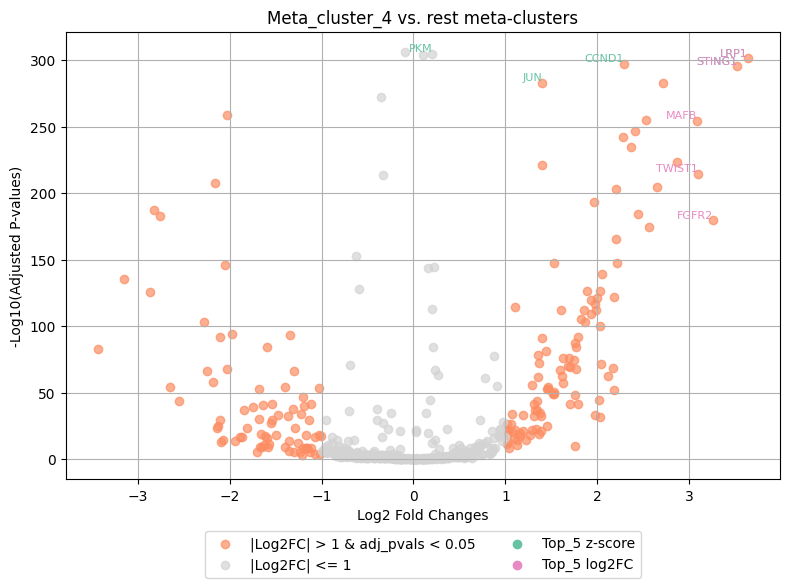

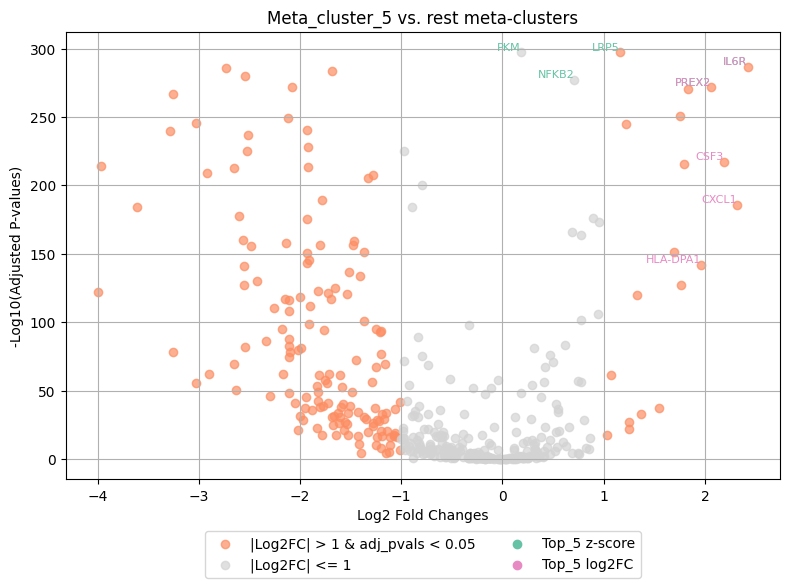

In [21]:
# Highlight top 5 scores and log2foldchange genes

# Filter out rows where -log10(pvals_adj) is not finite
rgdf["-log10(pvals_adj)"] = -np.log10(rgdf["pvals_adj"].replace(0, np.nan))
rgdf = rgdf[np.isfinite(rgdf["-log10(pvals_adj)"])]

# Create volcano plots with labels for top and bottom n logfoldchanges
n = 5  # Number of top and bottom labels
groups = rgdf["group"].unique()

# Updated code with magenta and light gray colors for specific spots
for group in groups:
    group_rgdf = rgdf[rgdf["group"] == group]

    # Sort and select top n and bottom n based on scores
    top_n_score = group_rgdf.nlargest(n, "scores")
    # bottom_n_score = group_rgdf.nsmallest(n, "scores")
    # labeled_points_score = pd.concat([top_n_score, bottom_n_score])
    labeled_points_score = pd.concat([top_n_score])

    top_n_fc = group_rgdf.nlargest(n, "logfoldchanges")
    # bottom_n_fc = group_rgdf.nsmallest(n, "logfoldchanges")
    # labeled_points_fc = pd.concat([top_n_fc, bottom_n_fc])
    labeled_points_fc = pd.concat([top_n_fc])

    plt.figure(figsize=(8, 6))

    # Plot points based on conditions for x-axis (logfoldchanges)
    plt.scatter(
        group_rgdf.loc[
            ((group_rgdf["logfoldchanges"] > 1) | (group_rgdf["logfoldchanges"] < -1)) & (group_rgdf["pvals_adj"] < 0.05),
            "logfoldchanges"
        ],
        group_rgdf.loc[
            ((group_rgdf["logfoldchanges"] > 1) | (group_rgdf["logfoldchanges"] < -1)) & (group_rgdf["pvals_adj"] < 0.05),
            "-log10(pvals_adj)"
        ],
        color='#fc8d62',
        alpha=0.7,
        label="|Log2FC| > 1 & adj_pvals < 0.05"
    )

    plt.scatter(
        group_rgdf.loc[
            (group_rgdf["logfoldchanges"] <= 1) & (group_rgdf["logfoldchanges"] >= -1),
            "logfoldchanges"
        ],
        group_rgdf.loc[
            (group_rgdf["logfoldchanges"] <= 1) & (group_rgdf["logfoldchanges"] >= -1),
            "-log10(pvals_adj)"
        ],
        color='lightgray',
        alpha=0.7,
        label="|Log2FC| <= 1"
    )

    # Add labels for the selected top/bottom n_score points
    for _, row in labeled_points_score.iterrows():
        plt.text(
            row["logfoldchanges"],
            row["-log10(pvals_adj)"],
            row["names"],
            fontsize=8,
            ha='right',
            va='bottom',
            color='#66c2a5'
        )

    # Add labels for the selected top/bottom n_fc points
    for _, row in labeled_points_fc.iterrows():
        plt.text(
            row["logfoldchanges"],
            row["-log10(pvals_adj)"],
            row["names"],
            fontsize=8,
            ha='right',
            va='bottom',
            color='#e78ac3'
        )

    # Add a custom legend for labeled points
    plt.scatter([], [], color='#66c2a5', label=f"Top_{n} z-score")
    plt.scatter([], [], color='#e78ac3', label=f"Top_{n} log2FC")

    plt.title(f"{group} vs. rest meta-clusters")
    plt.xlabel("Log2 Fold Changes")
    plt.ylabel("-Log10(Adjusted P-values)")

    # Place legend to the bottom of the plot
    plt.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.1),
        frameon=True,
        ncol=2
    )
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()


Here, instead of plotting ranked genes using Scanpy's scanpy.pl.rank_genes_groups function, which solely ranks genes based on their z-scores, I used a volcano plot to display all differentially expressed genes (DGE) and highlighted the top 5 genes by z-score and the top 5 genes by log2 fold-change.

I noticed that the top z-score genes differ from the top log2 fold-change genes. After further investigation, I concluded the following:

1. Z-scores measure how many standard deviations a gene's expression in a group deviates from the mean expression across all groups. This normalization makes the values comparable across groups with different expression scales or variability. In contrast, log2FC does not inherently account for variability (dispersion) in expression. A gene with high variance might exhibit a large fold-change but could be less statistically significant than a gene with lower variance and a smaller fold-change.

2. Z-scores directly relate to the statistical significance of differential expression, as they are derived from hypothesis testing (e.g., t-test, Wilcoxon rank-sum test). While log2FC provides the magnitude of change, it does not convey statistical confidence in the observed difference.

3. High z-scores often identify genes that are both highly expressed in the target group and consistently low in other groups, emphasizing specificity. This is especially useful for identifying marker genes. In contrast, log2FC highlights genes with large expression differences but does not guarantee specificity across groups.

Thus, for exploratory analysis and marker gene identification, z-scores are often more practical, as they balance magnitude and statistical significance. However, if downstream interpretation requires understanding the biological magnitude of expression changes, supplementing z-score analysis with log2FC data may be necessary. For this analysis, I will follow Scanpy's convention and focus on top z-score genes.

# Compare cell morphological differences

**Anisotropy**

Anisotropy measures how much a shape deviates from being isotropic (i.e., uniformly shaped in all directions, like a circle or sphere). A perfectly round cell has low anisotropy, while an elongated or irregularly shaped cell has high anisotropy. For example, fibroblasts, which are typically elongated, exhibit higher anisotropy than round cells like lymphocytes.

Anisotropy can be calculated using metrics such as the eigenvalues of the covariance matrix of a cell's boundary points. In MERFISH, anisotropy is defined as the ratio of the length of the major axis of the cell to the length of its minor axis. Values range from 1 (perfect circle) to larger numbers for highly elongated shapes.


**Perimeter-Area Ratio**
The perimeter-area ratio is the ratio of the perimeter of a cell's boundary to its area. It indicates how "spiky" or irregular the cell boundary is relative to its size. A high perimeter-area ratio suggests a complex, irregular boundary, whereas a low ratio indicates a smoother, more regular shape.

A perfect circle has the lowest possible ratio for a given area because it minimizes the perimeter for a fixed area. For example, cells with many filopodia or lamellipodia (extensions) will have a higher perimeter-area ratio compared to smooth-edged cells. Typical ranges include:

Smooth and round cells: 0.2–1.0 (lower ratios for regular shapes).
Irregular or spiky cells: 1.5–5.0 (higher ratios for complex boundaries).
Extreme cases: >5.0 (e.g., cells with many filopodia or blebs).


**Solidity**
Solidity quantifies the proportion of a shape's area relative to the area of its convex hull. Lower values correspond to more complex or non-convex shapes. For instance:

Smooth and regular cells (e.g., epithelial cells): 0.8–1.0.
Irregular or spiky cells (e.g., migratory cells like fibroblasts or dendritic cells): 0.5–0.8.
Highly irregular shapes (e.g., cancer cells with membrane blebbing): <0.5.<br>
In cancer biology, increased anisotropy and perimeter-area ratio are often associated with invasive behavior, while decreased solidity is frequently linked to invasive phenotypes or metastasis.

In [22]:
features_to_compare = ['volume','anisotropy', 'perimeter_area_ratio', 'solidity']

In [23]:
# this function was modified from https://stackoverflow.com/questions/11517986/indicating-the-statistically-significant-difference-in-bar-graph

def violinplot_annotate_brackets(
    num1, num2, data, centers, heights,
    dh=0.05, barh=0.05, fs=None, maxasterix=None, display_mode="p-value", y_offset=0.2, current_max_y=None
):
    """
    Annotate violin plot with p-values or asterisks, and automatically shift brackets upward.

    :param num1: number of left violin to put bracket over
    :param num2: number of right violin to put bracket over
    :param data: p-value (float) or a string to write
    :param centers: x-axis positions of violins
    :param heights: maximum heights of violins
    :param dh: base height offset over violin max height in axes coordinates (0 to 1)
    :param barh: bracket height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterisks to write (for very small p-values)
    :param display_mode: 'p-value' to show p-values, 'asterisks' to show significance levels with asterisks
    :param y_offset: additional height offset for subsequent brackets
    :param current_max_y: the current maximum y-coordinate to determine placement
    """

    # Determine text based on display mode
    if display_mode == "p-value":
        text = f"p = {data:.3g}" if isinstance(data, (float, int)) else data
    elif display_mode == "asterisks":
        if isinstance(data, str):  # Directly use provided string if any
            text = data
        else:  # Generate asterisks based on p-value
            text = ''
            p = 0.05
            while data < p:
                text += '*'
                p /= 10.
                if maxasterix and len(text) == maxasterix:
                    break
            if len(text) == 0:
                text = 'n. s.'

    # Get the coordinates for the bracket
    lx, ly = centers[num1], heights[num1]
    rx, ry = centers[num2], heights[num2]

    # Calculate the initial y position for the bracket
    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh = dh * (ax_y1 - ax_y0)
    barh = barh * (ax_y1 - ax_y0)
    base_y = max(ly, ry) + dh

    # If a current maximum y-coordinate is provided, shift the bracket upwards
    if current_max_y is not None:
        y = max(base_y, current_max_y + y_offset)
    else:
        y = base_y

    # Draw the bracket
    barx = [lx, lx, rx, rx]
    bary = [y, y + barh, y + barh, y]
    mid = ((lx + rx) / 2, y + barh)

    plt.plot(barx, bary, c='black')

    # Add text for the significance
    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)

    # Return the y-coordinate of the current bracket for further shifting
    return y + barh


Analyzing volume
                       count        mean         std         min         25%  \
manual_meta_cluster                                                            
Meta_cluster_1       19577.0  654.703026  298.371208  100.178046  448.493616   
Meta_cluster_2       10720.0  769.354370  364.459940  100.213575  516.031193   
Meta_cluster_4        8025.0  743.992466  311.663647  100.116200  536.613477   
Meta_cluster_5       26372.0  623.217661  318.215126  100.030683  385.956059   

                            50%         75%          max  
manual_meta_cluster                                       
Meta_cluster_1       632.037619  821.940093  2419.663066  
Meta_cluster_2       716.493819  966.384322  2498.916118  
Meta_cluster_4       718.137810  916.762687  2439.695344  
Meta_cluster_5       589.251997  806.017063  2346.191739  
Kruskal-Wallis H Test Statistic: 1955.2161929696158
P-value: 0.0


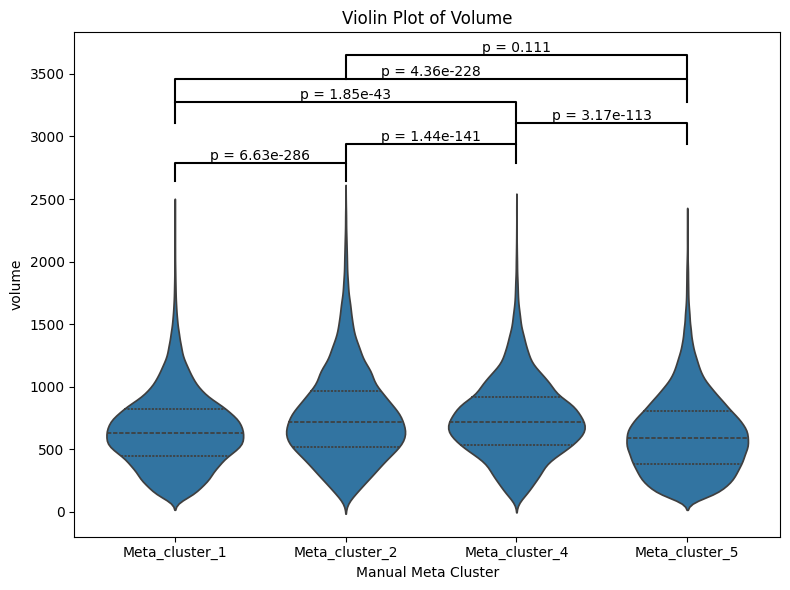

Analyzing anisotropy
                       count      mean       std       min       25%  \
manual_meta_cluster                                                    
Meta_cluster_1       19577.0  1.432207  0.290427  1.000833  1.222429   
Meta_cluster_2       10720.0  1.478939  0.337105  1.004478  1.238294   
Meta_cluster_4        8025.0  1.428008  0.288130  1.005565  1.220891   
Meta_cluster_5       26372.0  1.513147  0.358248  1.004383  1.259690   

                          50%       75%       max  
manual_meta_cluster                                
Meta_cluster_1       1.370906  1.569759  3.634181  
Meta_cluster_2       1.399510  1.627417  3.813373  
Meta_cluster_4       1.362950  1.569495  3.542801  
Meta_cluster_5       1.431332  1.676620  6.296915  
Kruskal-Wallis H Test Statistic: 688.2377693584422
P-value: 7.456005712463552e-149


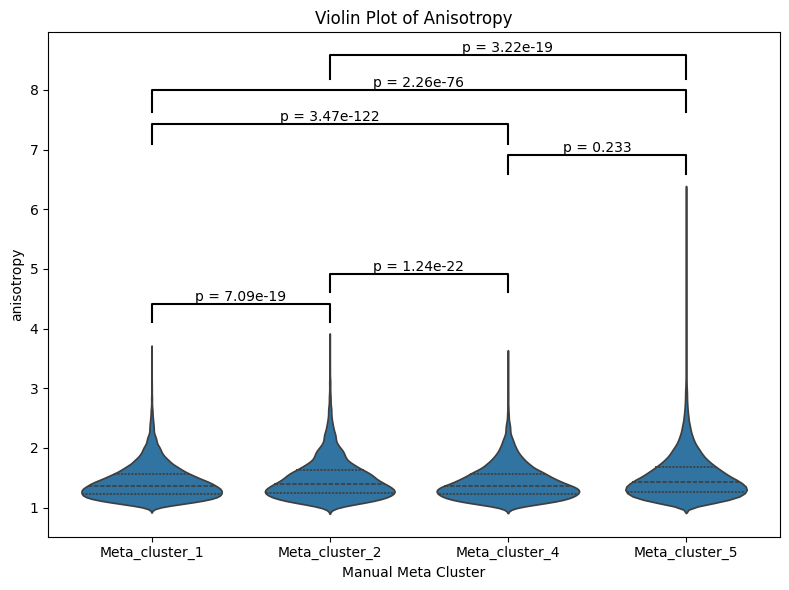

Analyzing perimeter_area_ratio
                       count      mean       std       min       25%  \
manual_meta_cluster                                                    
Meta_cluster_1       19577.0  0.561071  0.160692  0.258287  0.452606   
Meta_cluster_2       10720.0  0.512235  0.144587  0.246124  0.415739   
Meta_cluster_4        8025.0  0.514836  0.141647  0.271357  0.423190   
Meta_cluster_5       26372.0  0.588433  0.175712  0.260424  0.462567   

                          50%       75%       max  
manual_meta_cluster                                
Meta_cluster_1       0.521442  0.625369  3.069111  
Meta_cluster_2       0.481825  0.569170  1.547352  
Meta_cluster_4       0.481945  0.563980  1.567204  
Meta_cluster_5       0.545235  0.672427  1.534910  
Kruskal-Wallis H Test Statistic: 2665.8930747103295
P-value: 0.0


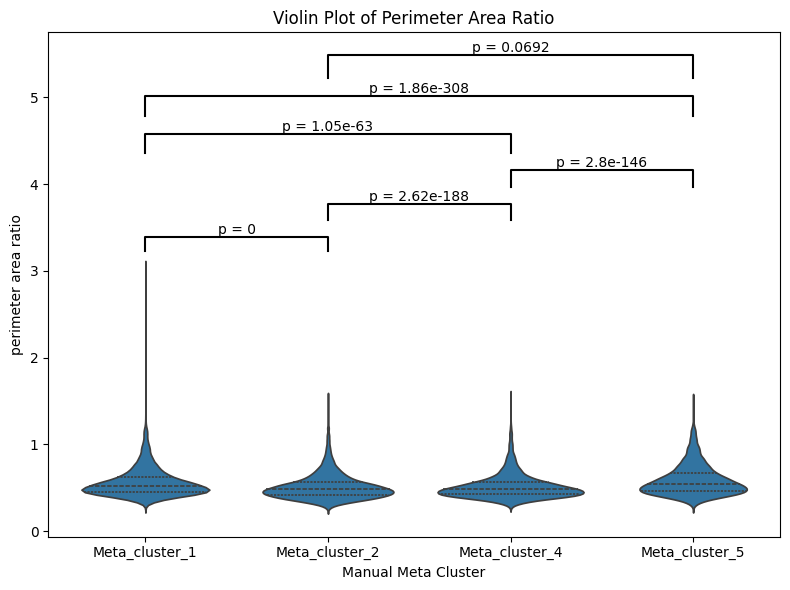

Analyzing solidity
                       count      mean       std       min       25%  \
manual_meta_cluster                                                    
Meta_cluster_1       19577.0  6.533787  0.517328  1.827777  6.343568   
Meta_cluster_2       10720.0  6.612748  0.424549  3.084910  6.474302   
Meta_cluster_4        8025.0  6.581420  0.455380  2.835843  6.423432   
Meta_cluster_5       26372.0  6.552516  0.507576  2.933484  6.368672   

                          50%       75%  max  
manual_meta_cluster                           
Meta_cluster_1       6.703358  6.895906  7.0  
Meta_cluster_2       6.743575  6.898944  7.0  
Meta_cluster_4       6.731563  6.890067  7.0  
Meta_cluster_5       6.713297  6.910418  7.0  
Kruskal-Wallis H Test Statistic: 72.21858362079186
P-value: 1.4291959584932944e-15


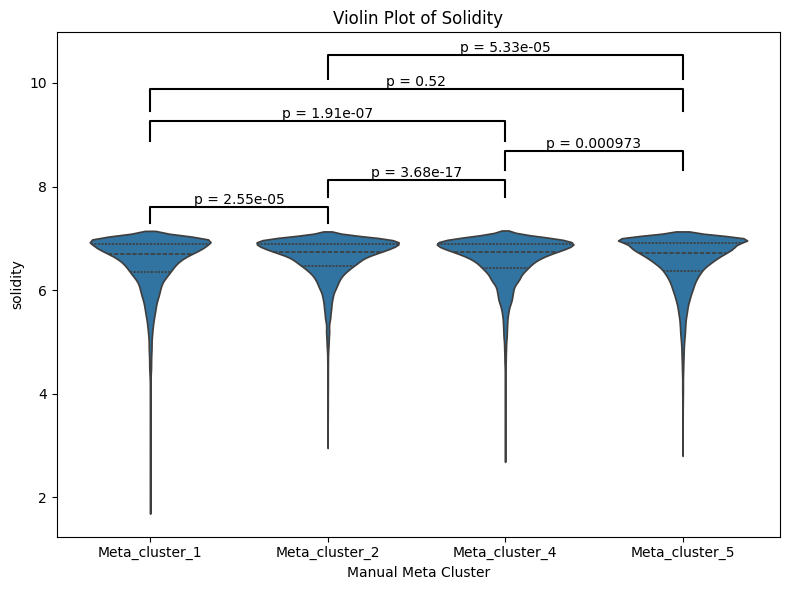

In [24]:
from scipy.stats import kruskal
from scipy.stats import ranksums


for feature in features_to_compare:

  print(f'Analyzing {feature}')
  print(ad.obs.groupby("manual_meta_cluster", observed=True)[feature].describe())

  # Group the data by 'manual_meta_cluster'
  grouped = ad.obs.groupby("manual_meta_cluster", observed=True)[feature]

  # Prepare the data for the Kruskal-Wallis test (non-parametric statistical test one-way ANOVA on ranks)
  groups = [group.values for _, group in grouped]

  # Perform the Kruskal-Wallis H test
  stat, p_value = kruskal(*groups)

  # Output the results
  print("Kruskal-Wallis H Test Statistic:", stat)
  print("P-value:", p_value)


  # proceed with pairwise test and plot
  df = ad.obs[["manual_meta_cluster", feature]].dropna()

  # Create violin plot
  plt.figure(figsize=(8, 6))
  sns.violinplot(data=df, x="manual_meta_cluster", y=feature, inner="quartile")
  # plt.title(f"Violin Plot of {feature.capitalize().replace('_', ' ')}")
  plt.title(f"Violin Plot of {' '.join([feat.capitalize() for feat in feature.split('_')])}")

  # Get violin centers and heights
  violin_centers = np.arange(len(df["manual_meta_cluster"].unique()))  # X-axis positions
  violin_heights = df.groupby("manual_meta_cluster", observed=True)[feature].max().values  # Max heights

  # Perform pairwise comparisons
  pairs = [(0, 1), (1, 2), (2, 3), (0, 2), (0, 3), (1, 3)]  # Example pairs: (A vs. B), (B vs. C), (A vs. C)
  current_max_y = None  # Start tracking the maximum y-coordinate

  for num1, num2 in pairs:
      data1 = df[df["manual_meta_cluster"] == df["manual_meta_cluster"].unique()[num1]][feature]
      data2 = df[df["manual_meta_cluster"] == df["manual_meta_cluster"].unique()[num2]][feature]
      stat, p_value = ranksums(data1, data2)

      # Annotate brackets and update the maximum y-coordinate
      current_max_y = violinplot_annotate_brackets(
          num1, num2, p_value, violin_centers, violin_heights,
          display_mode="p-value", current_max_y=current_max_y, y_offset=0.2
      )

  # Show plot
  plt.xlabel("Manual Meta Cluster")
  plt.ylabel(feature.replace("_", " "))
  plt.tight_layout()
  plt.show()

In [25]:
for feature in features_to_compare:

  print(f'Analyzing {feature}')
  print(ad.obs.groupby("manual_meta_cluster", observed=True)[feature].describe())
  # print(ad.obs.groupby("manual_meta_cluster", observed=True)[feature].median())
  # print(ad.obs.groupby("manual_meta_cluster", observed=True)[feature].max())
  print(f'\n')

Analyzing volume
                       count        mean         std         min         25%  \
manual_meta_cluster                                                            
Meta_cluster_1       19577.0  654.703026  298.371208  100.178046  448.493616   
Meta_cluster_2       10720.0  769.354370  364.459940  100.213575  516.031193   
Meta_cluster_4        8025.0  743.992466  311.663647  100.116200  536.613477   
Meta_cluster_5       26372.0  623.217661  318.215126  100.030683  385.956059   

                            50%         75%          max  
manual_meta_cluster                                       
Meta_cluster_1       632.037619  821.940093  2419.663066  
Meta_cluster_2       716.493819  966.384322  2498.916118  
Meta_cluster_4       718.137810  916.762687  2439.695344  
Meta_cluster_5       589.251997  806.017063  2346.191739  


Analyzing anisotropy
                       count      mean       std       min       25%  \
manual_meta_cluster                                  

Caveats in This Analysis
1. Large Sample Size Effect
With thousands of observations, statistical tests can detect very small differences between groups as significant. This sensitivity may result in "overestimating significance," where even trivial differences yield low p-values.
While p-values may reflect statistically significant results, they do not always indicate practical or meaningful differences.

2. Histological Cross-Section
Cell morphology is derived from histological sections, meaning that cells may be sectioned along random planes. How accurately a cell's true shape is preserved is a critical consideration in morphological analysis.
Additionally, cell shape (e.g., roundness) can be influenced by parameters used in cell segmentation. Improper parameter selection or overfitting may produce artificial effects.

Thus, anisotropy, perimeter-area ratio, and solidity are valuable supplementary parameters for analysis but should not be considered deterministic in this case.